<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 8 Day 1</div>
<div style="text-align: right">Dino Konstantopoulos, 19 February 2020, with material by Cam Davidson-Pilon, Max Margenot, and Thomas Wiecki</div>


# Bayesian methods for determining model parameters

In this notebook, we introduce Bayesian methodology by seeing how posteriors are affected by priors and data likelhood. We then demonstrate how you can use Bayesian probabilistic programming libraries like `PyMC3` to infer model parameters, which are probability distributions themselves according to Bayesian thinking. Their means give you the most probably values of the parameters, while their standard deviations tell you how much of a mistake you might be making in assuming each mean model parameter. With this information in hand, you can both use the model to generate simulated data *and also* have an idea of how much mistake you are making in the simulation. No need for p-values.

Bayesian methodology is very similar to genetic algorithms. But instead of roulette wheel selection, crossover and mutation, Bayesian methods posit a model, then leverage Bayes' formula to refine probabilities of model parameters given new data (warping model parameter state space), then navigate state space by visiting regions of higher posterior probability.

It's almost like solving a Rubik's cube. You build a model for how you think it should look, then you try to get closer and closer to the solution, sometimes probabilistically because you have no idea about the theory behind it..

<br />
<center>
<img src="ipynb.images/rubik.gif" width=400 />
</center>

# 1. The Bayesian landscape

When we create a model with $N$ parameters that we want to solve with Baeysian inference, we are implicitly creating an $N$ dimensional space for the prior distribution of each paramater to live in. Associated with the space is an extra dimension, which we can describe as the *surface*, or *manifold*, that sits on top of the space, that reflects the *prior probability* of a particular point. The surface on the space is defined by our prior distributions. 

For example, if we have two unknowns $p_1$ and $p_2$, and priors for both are $\text{Uniform}(0,5)$, the space created is a square of length 5 and the surface is a flat plane that sits on top of the square (representing that every point is equally likely). 

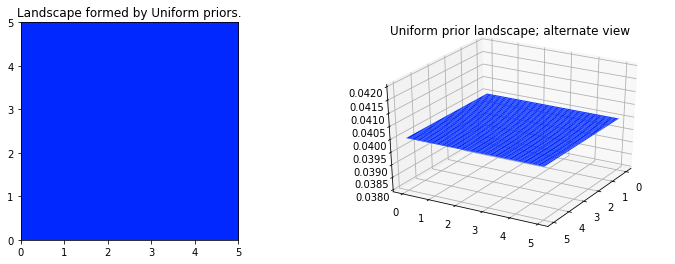

In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view");


Alternatively, if the two priors are $\text{Exp}(3)$ and $\text{Exp}(10)$, then the space is all positive numbers on the 2-D plane, and the surface induced by the priors looks like a water fall that starts at the point (0,0) and flows over the positive numbers. Do you want to see what this looks like? I do.

The plots below visualize this. The more dark red the color, the more prior probability is assigned to that location. Conversely, areas with darker blue represent that our priors assign very low probability to that location. 

In [ ]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view");


These are simple examples in 2D space, where our brains can understand surfaces well. In practice, spaces and surfaces generated by our priors are much higher dimensional and *difficult* to grok.

If these surfaces describe our *prior distributions* on the unknowns, what happens to our space after we incorporate our observed data $X$? 

The data $X$ does not change the space, but it changes the surface of the space by *pulling and stretching the fabric of the prior surface* to reflect where the true parameters likely live. More data means more pulling and stretching, and our original shape becomes mangled or insignificant compared to the newly formed shape. Less data, and our original shape is more present.  Regardless, the resulting surface describes the *posterior distribution*. 

>**ANALOGY**: Probabilities allowed me to talk about quantum physics with you. Now Bayesian estimation will let me talk about Einstein's general relativity: Evidence warps the space of prior distributions much in the same way that planterary bodies warp space and create the force of gravity through geometry!

</br >
<center>
<img src="ipynb.images/spacetime-curvature.png" width=400 />
    Spacetime curvature gives rise to gravity
</center>

For two dimensions, data essentially *pushes up* the original surface to make *tall mountains*. The tendency of the observed data to *push up* the posterior probability in certain areas is checked by the prior probability distribution, so that small prior probability means more resistance. Thus in the double-exponential prior case above, a mountain (or multiple mountains) that might erupt near the (0,0) corner would be much higher than mountains that erupt closer to (5,5), since there is more resistance (low prior probability) near (5,5). Peaks always reflect the posterior probability of where the true parameters are likely to be found. 

>Note that if the prior has assigned a probability of 0, then no posterior probability will be assigned there. 

Suppose the priors mentioned above represent different parameters $\lambda$ of two Poisson distributions. We observe a  datapoint and visualize the new landscape. This datapoint is a random variate from a 2D Poisson distribution. Think about it as the number of emails you recieve and the number of text messages, in one day.

Here is your datapoint:

In [ ]:
# create observed data

# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 1

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)

data

In [ ]:
data[:, 0]

In [ ]:
data[:, 1]

This is the **likelihood**, which in each dimension is the probability density function (actually probability mass function since our random variable is discrete rather than continuous) of the Poisson distribution:

In [ ]:
# plotting details.
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])
L

These are our **priors**: How we think the data *will be* distributed. We start with **uniform** priors:

In [ ]:
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

Now, we suddenly observe a datapoint! So this is our **posterior**, as given by Bayes' formula (we omit the denominator):

In [ ]:
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

Given the new datapoint, given that observation, we now expect to observe data coming in with probability contours as pictured above.

Now, what if we started with exponential priors instead? In other words, we think there is a ***data fountain*** at the origin, and we expected our data to come from there instead. Then our posterior becomes:

In [ ]:
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

That is how we would expect data to flow if it flowed from the origin!

Now, we observe a datapoint! Yay! We're not alone in the universe :-)

How does that modify our posterior?

In [ ]:
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);

We see that our datapoint created a mountain, jusj like before, but now the top of that mountain is not the datapoint itself. Because our prior was a data fountain at the origin, it *fights* with our datapoint and the result of that tectonic shift is the landscape you see pictured above.

Let's bring this all together into a *combined* plot, and introduce more datapoints! It's like playing God with the tectonic plates on earth! 

We color in red our datapoints, in green the expectation which is nothing more than the $\lambda$s of our Poissons. You should be able to see that as you increase the number of datapoints, your posterior gets tighter and tighter (and taller and taller) and the peak closer and colser to the theoretical expecation, which is where the green point lies.

In [ ]:
#
# create observed data
#

# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 3

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print(data)

#
# Likelihood function fron the observed data
#

x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

#
# plots
#

figsize(12.5, 12)
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="g", s=50, edgecolor="none")
for _ in range(N):
    plt.scatter(data[_][0], data[_][1], c="r", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="g", s=50, edgecolor="none")
for _ in range(N):
    plt.scatter(data[_][0], data[_][1], c="r", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);


The highest points on the mountain, corresponding the the darkest red, are biased towards (0,0) in the exponential case, which is the result from the exponential prior putting more prior weight in the (0,0) corner.

The green dot represents the true parameters, or **expectation**, and as we increase the number of datapoints, our mountain peak gets closer and closer to the expectation.

Try changing the sample size to other values (try 5, 10, 100) and observe how the mountain posterior changes.

That is the essence of Bayesian dynamics.

## 2. Exploring the landscape using PyMC3

Exploring the deformed posterior space generated by our prior surface and observed data is a great eercise. However, we cannot naively search the space: Traversing $N$-dimensional space is exponentially difficult in $N$: the size of the space quickly blows-up as we increase $N$ ([the curse of dimensionality](http://en.wikipedia.org/wiki/Curse_of_dimensionality)).

How do we find these hidden mountains? The idea behind Markov Chain Monte Carlo algorithms is to perform an ***intelligent search*** of the space.

MCMC algorithms like **Metropolis** return **samples** from the posterior distribution, not the distribution itself. 

MCMC performs a task similar to repeatedly asking "*How likely is this pebble I found to be from the mountain I am searching for*?", and completes its task by returning thousands of accepted pebbles in hopes of reconstructing the original mountain. In MCMC and PyMC3 lingo, the returned sequence of "*pebbles*" are the samples, cumulatively called the **traces**. 

MCMC does this by exploring nearby positions and moving into areas with higher probability. MCMC moves towards a *broader area* in the space and randomly walks in that area, picking up samples from that area.

### Why do we pick up thousands of samples?

At first, returning thousands of samples might sound like being an inefficient way to describe the posterior distributions. 

But.. what other possibilities do we have?

- Returning a mathematical formula for the *mountain ranges* would involve describing a N-dimensional surface with arbitrary peaks and valleys. I don't really know how to do that. Do you? If you do, please tell me!

- Returning the *peak* of the landscape, while mathematically possible and a sensible thing to do as the highest point corresponds to most probable estimate of the unknowns, ignores the shape of the landscape, which  is ***very important*** in determining posterior confidence in unknowns. 

Besides computational reasons, the strongest reason for returning samples is that we can easily use **the Law of Large Numbers** to solve otherwise intractable problems: With the thousands of samples, we can reconstruct the posterior surface by organizing them in a histogram, much like you were easily able to generate fake data when I gave you a histogram.


### MCMC algorithms

There is a large family of algorithms that perform MCMC, not just Metropolis. Most of these algorithms can be expressed at a high level as follows:

1. Start at current position.
2. Propose moving to a new position (investigate a pebble near you).
3. Accept/Reject the new position based on the position's adherence to the data and prior distributions (ask if the pebble likely came from the mountain).
4.  1.  If you accept: Move to the new position. Return to Step 1.
    2. Else: Do not move to new position. Return to Step 1. 
5. After a large number of iterations, return all accepted positions.

This way we move in the general direction towards the regions where the posterior distributions live, and collect samples sparingly on the journey. Once we reach the posterior distribution, we can easily collect samples as they likely all belong to the posterior distribution. 

If the current position of the MCMC algorithm is in an area of extremely low probability, which is often the case when the algorithm begins (typically at a random location in the space), the algorithm will move in positions *that are likely not from the posterior* but better than everything else nearby. Thus the first moves of the algorithm are not reflective of the posterior (that is why we often *throw away* the first samples.

In the above algorithm's pseudocode, notice that only the current position matters (new positions are investigated only near the current position). This property as *memorylessness*, i.e. the algorithm does not care *how* it arrived at its current position, only that it is there. That is why the chain is **Markovian**.

### Other approximation solutions to the posterior

Besides MCMC, there are other procedures available for determining the posterior distributions. [Gaussian Processes](https://en.wikipedia.org/wiki/Generalized_linear_model) (GPs) are infinite-dimensional generalization of multivariate normal distributions. A machine-learning algorithm that involves a Gaussian process uses lazy learning and a measure of the similarity between points (the kernel function) to predict the value for an unseen point from training data. The prediction is not just an estimate for that point, but also has uncertainty information. Another method is [Variational Bayes](http://en.wikipedia.org/wiki/Variational_Bayesian_methods). All three methods, GPs, Variational Bayes, and classical MCMC have their pros and cons.

# 3. Lab: Unsupervised Clustering using a Mixture Model


Suppose we are given the following dataset:

In [ ]:
figsize(12.5, 4)
data = np.loadtxt("data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="b", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")


In [ ]:
data.shape

What does the data suggest? It appears the data has a bimodal form, that is, it appears to have two peaks, one near 120 and the other near 200. Perhaps there are *two clusters* within this dataset. 

Do you know of a good analytic function that has two peaks? I don't. So, let's assume it comes from ***mixing two analytic functions***, each with their own peak. Like good data scientists, we start with normal distributions. Let's try the following generative technique:

1. For each data point, choose cluster 1 with probability $p$, else choose cluster 2. 
2. Draw a random variate from a Normal distribution with parameters $\mu_i$ and $\sigma_i$ where $i$ was chosen in step 1.
3. Repeat.

This algorithm would create a similar effect as the observed dataset, so ***we choose this as our model***. This is the ***art*** of data science. Now we're ready for the ***science*** of data science: Finding the right parameters.

We do not know $p$ or the parameters of the Normal distributions. So we must infer, or *learn*, these unknowns. This is what Bayesian MCMC programms allow us to do.

*Ready*?

Denote the Normal distributions $\text{N}_0$ and $\text{N}_1$. Both currently have *unknown* **mean** and **standard deviation**, denoted $\mu_i$ and $\sigma_i, \; i =0,1$ respectively. A specific data point can be from either $\text{N}_0$ or $\text{N}_1$, and we assume that the data point is assigned to $\text{N}_0$ with probability $p$.

An appropriate way to assign data points to clusters is to use a PyMC3 `Categorical` stochastic variable. Its parameter is a $k$-length array of probabilities that must sum to one and its `value` attribute is an integer between 0 and $k-1$ randomly chosen according to the crafted array of probabilities (in our case $k=2$). 

*A priori*, we do not know what the probability of assignment to cluster 1 is, so we form a uniform variable on $(0, 1)$. We call call this $p_1$. The probability of belonging to cluster 2 is therefore $p_2 = 1 - p_1$.

Unfortunately, we can't we just give `[p1, p2]` to our `Categorical` variable. PyMC3 uses `Theano` under the hood to construct the models so we need to use `theano.tensor.stack()` to combine $p_1$ and $p_2$ into a vector that it can understand. We pass this vector into the `Categorical` variable as well as the `testval` parameter to give our variable an idea of where to start from: 300 random integers representing our 300 datapoints, either belonging to cluster 0 or cluster 1.

In [ ]:
import pymc3 as pm
import theano.tensor as T

with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape = data.shape[0],
                                testval = np.random.randint(0, 2, data.shape[0]))
    
print("prior assignment, with p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:100])

Looking at the above dataset, I would guess that the standard deviations of the two Normals are different. To maintain ignorance of what the standard deviations might be, we will initially model them as uniform on 0 to 100. We will include both standard deviations in our model using a single line of PyMC3 code:

    sds = pm.Uniform("sds", 0, 100, shape=2)

Notice that we specified `shape=2`: we are modeling both $\sigma$s as a *single* PyMC3 variable. Note that this does not induce a necessary relationship between the two $\sigma$s, it is simply for succinctness.

We also need to specify priors on the centers of the clusters. The centers are really the $\mu$ parameters in these Normal distributions. Their priors can be modeled by a Normal distribution. Looking at the data, I have an idea where the two centers might be &mdash; I would guess somewhere around 120 and 190 respectively, though I am not very confident in these eyeballed estimates. Hence I will set $\mu_0 = 120, \mu_1 = 190$ and $\sigma_0 = \sigma_1 = 10$.

Let's do all this.

In [ ]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)
    
print("Random assignments: ", assignment.tag.test_value[:100], "...")
print("Assigned center: ", center_i.tag.test_value[:100], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:100])

So that is what we start with: random assignments for each datapoint.

Notice how we continue to build the model within the context of `Model()`. This automatically adds the variables that we create to our model. As long as we work within this context we will be working with the same variables that we have already defined. Any sampling that we do within the context of `Model()` will be done only on the model in which we are working. 

We will tell our model to explore the space that we have so far defined by defining the sampling methods, in this case `Metropolis()` for our continuous variables and `ElemwiseCategorical()` for our categorical variable. 

We will use these sampling methods to explore the space by using `sample(iterations, step)`, where `iterations` is the number of steps we wish the algorithm to perform and `step` is the way in which we want to handle those steps. 

We use our combination of `Metropolis()` and `ElemwiseCategorical()` for the `step` and sample 25,000 `iterations:

In [ ]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

We have stored the paths of all our variables, or **traces**, in the `trace` variable. These paths are the routes the unknown parameters (centers, precisions, and $p$) have taken thus far in our exploration of our state space.

The individual path of each variable is indexed by the PyMC3 variable `name` that we gave that variable when defining it within our model. For example, `trace["sds"]` will return a `numpy array` object that we can then index and slice as we would any other `numpy array` object. 

In [ ]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

# pretty colors
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();


Notice the following characteristics:

1. The traces converge, not to a single point, but to a *distribution* of possible points. This is *convergence* in an MCMC algorithm.
2. Inference using the first few thousand points is a bad idea, as they are unrelated to the final distribution we are interested in. Thus is it a good idea to discard those samples before using the samples for inference. We call this period before converge the *burn-in period*.
3. The traces appear as a *random walk* around the space, that is, the paths exhibit correlation with previous positions. This is both good and bad. We will always have correlation between current positions and the previous positions, but too much of it means we are not exploring the space well. This will be detailed in the Diagnostics section later below.

To achieve further convergence, we will perform *more* MCMC steps. In the pseudo-code algorithm of MCMC above, the only position that matters is the current position (new positions are investigated near the current position), implicitly stored as part of the `trace` object. To continue where we left off, we pass the `trace` that we have already stored into the `sample()` function with the same step value. The values that we have already calculated will not be overwritten. This ensures that our sampling continues where it left off in the same way that it left off. 

We will sample the MCMC ***fifty thousand*** more times and visualize progress below:

In [ ]:
with model:
    trace = pm.sample(50000, step=[step1, step2], trace=trace)

In [ ]:
center_trace = trace["centers"][25000:]
prev_center_trace = trace["centers"][:25000]
center_trace.shape

In [ ]:
center_trace[:,1].shape

In [ ]:
figsize(12.5, 4)

x = np.arange(25000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(25000, 75000)
plt.plot(x, center_trace[:50000, 0], label="new trace of center 0", lw=lw, c="#348ABD")
plt.plot(x, center_trace[:50000, 1], label="new trace of center 1", lw=lw, c="#A60628")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");


### Cluster Investigation

Our main challenge is to identify the clusters. We have determined posterior distributions for our unknowns. We plot the posterior distributions of the center and standard deviation variables below:

In [ ]:
figsize(11.0, 4)
std_trace = trace["sds"][25000:]
prev_std_trace = trace["sds"][:25000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()


The MCMC algorithm has proposed that the most likely centers of the two clusters are near 120 and 200 respectively. The most likely standard deviation is 50 for cluster 0, and 22 for cluster 1.

We are also given the posterior distributions for the labels of the data point, which is present in `trace["assignment"]`. Below is a visualization of this. The y-axis represents a subsample of the posterior labels for each data point. The x-axis are the sorted values of the data points. A red square is an assignment to cluster 1, and a blue square is an assignment to cluster 0. 

In [ ]:
import matplotlib as mpl
figsize(10, 10)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(trace["assignment"][::400, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");


Looking at the above plot, it appears that the most uncertainty is between 150 and 170. The above plot slightly misrepresents things, as the x-axis is not a true scale (it displays the value of the $i$th sorted data point). A more clear diagram is below, where we estimate the *frequency* of each data point belonging to labels 0 and 1:

In [ ]:
figsize(10, 5)
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");


Even though we modeled the clusters using Normal distributions, we didn't get just two Normal distributions that *best* fit the data, but a distribution of values for the Normal distributions' parameters. 

>Repeat this twice more, because it's *key* to Bayesian estimation.

Now, how can we choose just a single pair of values for the mean and variance and determine a *sorta-best-fit* gaussian? 

One quick way is to use the *mean* of the posterior distributions. Below we overlay the Normal density functions, using the mean of the posterior distributions as the chosen parameters, with our observed data:

In [ ]:
norm = stats.norm
figsize(15, 5)
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()

plt.hist(data, bins=20, histtype="step", normed=True, color="k",
     lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");


### Important: Don't mix posterior samples

In the above example, a possible (though less likely) scenario is that cluster 0 has a very large standard deviation, and cluster 1 has a small standard deviation. This would still satisfy the evidence, albeit less so than our original inference. Alternatively, it would be incredibly unlikely for *both* distributions to have a small standard deviation, as the data does not support this hypothesis at all. Thus the two standard deviations are *dependent* on each other: if one is small, the other must be large. In fact, *all* the unknowns are related in a similar manner. For example, if a standard deviation is large, the mean has a wider possible space of realizations. Conversely, a small standard deviation restricts the mean to a small area. 

During MCMC, we are returned vectors representing samples from the unknown posteriors. Elements of different vectors cannot be used together, as this would break the above logic: perhaps a sample has returned that cluster 1 has a small standard deviation, hence all the other variables in that sample would incorporate that and be adjusted accordingly. It is easy to avoid this problem though, just make sure you are indexing traces correctly. 

Another small example to illustrate the point. Suppose two variables, $x$ and $y$, are related by $x+y=10$. We model $x$ as a Normal random variable with mean 4 and explore 500 samples.  

In [ ]:
import pymc3 as pm

with pm.Model() as model:
    x = pm.Normal("x", mu=4, tau=10)
    y = pm.Deterministic("y", 10 - x)

    trace_2 = pm.sample(10000, pm.Metropolis())

plt.plot(trace_2["x"])
plt.plot(trace_2["y"])
plt.title("Displaying (extreme) case of dependence between unknowns");


As you can see, the two variables are not unrelated, and it would be wrong to add the $i$th sample of $x$ to the $j$th sample of $y$, unless $i = j$.

### Returning to Clustering: Prediction
The above clustering can be generalized to $k$ clusters. Choosing $k=2$ allowed us to visualize the MCMC better, and examine some very interesting plots. 

What about prediction? Suppose we observe a new data point, say $x = 175$, and we wish to label it to a cluster. It is foolish to simply assign it to the *closer* cluster center, as this ignores the standard deviation of the clusters, and we have seen from the plots above that this consideration is very important. More formally: we are interested in the *probability* (as we cannot be certain about labels) of assigning $x=175$ to cluster 1. Denote the assignment of $x$ as $L_x$, which is equal to 0 or 1, and we are interested in $P(L_x = 1 \;|\; x = 175 )$.  

A naive method to compute this is to re-run the above MCMC with the additional data point appended. The disadvantage with this method is that it will be slow to infer for each novel data point. Alternatively, we can try a *less precise*, but much quicker method. 

We will use Bayes Theorem for this:

$$ P( A | X ) = \frac{ P( X  | A )P(A) }{P(X) }$$

In our case, $A$ represents $L_x = 1$ and $X$ is the evidence we have: we observe that $x = 175$. For a particular sample set of parameters for our posterior distribution, $( \mu_0, \sigma_0, \mu_1, \sigma_1, p)$, we are interested in asking "*is the probability that $x$ is in cluster 1 **greater** than the probability it is in cluster 0*?", where the probability is dependent on the chosen parameters.

\begin{align}
& P(L_x = 1| x = 175 ) \gt P(L_x = 0| x = 175 ) \;\;\;? \\\\[5pt]
& \frac{ P( x=175  | L_x = 1  )P( L_x = 1 ) }{P(x = 175) } \gt \frac{ P( x=175  | L_x = 0  )P( L_x = 0 )}{P(x = 175) } \;\;\;?
\end{align}

As the denominators are equal, they can be ignored (and good riddance, because computing the quantity $P(x = 175)$ can be difficult). 

$$  P( x=175  | L_x = 1  )P( L_x = 1 ) \gt  P( x=175  | L_x = 0  )P( L_x = 0 ) \;\;\;?$$

Let's write this equation down probabilistically, and look at its mean to get the most realistic estimate:

In [ ]:
norm_pdf = stats.norm.pdf
p_trace = trace["p"][25000:]
prev_p_trace = trace["p"][:25000]
x = 175

v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])

print("Probability of belonging to cluster 1:", v.mean())


Giving us a probability instead of a label is a very useful thing. Instead of the naive 

    L = 1 if prob > 0.5 else 0


### Using `MAP` to improve convergence

If you rerun the sims you may notice that our results are not consistent: Perhaps your initial cluster division was more scattered, or perhaps less scattered. The problem is that our traces are a function of the *starting values* of the MCMC algorithm. 

It can be shown, mathematically, that letting the MCMC run long enough, by performing many steps, the algorithm *should forget its initial position*. In fact, this is what it means to say the MCMC converged (in practice though we can never achieve total convergence). Hence if we observe different posterior analysis, it is likely because our MCMC has not *fully converged yet*, and we should not use samples from it yet (we should use a larger burn-in period).

In fact, poor starting values can prevent any convergence, or significantly slow it down. Ideally, we would like to have the chain start at the *peak* of our landscape, as this is exactly where the posterior distributions exist. Hence, if we started at the peak, we could avoid a lengthy burn-in period and incorrect inference. Generally, we call this *peak* the [maximum a posterior](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) or, more simply, the *MAP*.

Of course, we do not know where the MAP is. PyMC3 provides a function that will approximate, if not find, the MAP location. In the PyMC3 main namespace is the `find_MAP` function. If you call this function within the context of `Model()`, it will calculate the MAP which you can then pass to `pm.sample()` as a `start` parameter.

    start = pm.find_MAP()
    trace = pm.sample(2000, step=pm.Metropolis, start=start)

The `find_MAP()` function has the flexibility of allowing the user to choose which optimization algorithm to use (after all, this is a optimization problem: we are looking for the values that maximize our landscape), as not all optimization algorithms are created equal. 

The default optimization algorithm in function call is the Broyden-Fletcher-Goldfarb-Shanno ([BFGS](https://en.wikipedia.org/wiki/Broyden-Fletcher-Goldfarb-Shanno_algorithm)) algorithm to find the maximum of the log-posterior. 

As an alternative, you can use other optimization algorithms from the `scipy.optimize` module. For example, you can use Powell's Method, a favourite of PyMC blogger [Abraham Flaxman](http://healthyalgorithms.com/) [1], by calling `find_MAP(fmin=scipy.optimize.fmin_powell)`. 

The default works well enough, but if convergence is slow or not guaranteed, you can experiment with Powell's method or the other algorithms available. 

The MAP can also be used as a solution to the inference problem, as mathematically it is the *most likely* value for the unknowns. But as mentioned earlier, this location ignores the uncertainty and doesn't return a distribution.

### Burn-in period

It is still a good idea to decide on a burn-in period, even if we are using `find_MAP()` prior to sampling, just to be safe. We can no longer automatically discard sample with a `burn` parameter in the `sample()` function as could be done in PyMC2, but it is easy enough to simply discard the beginning section of the trace just through array slicing. 

As one does not know when the chain has fully converged, a good rule of thumb is to discard the first *half* of your samples, sometimes up to 90% of the samples for longer runs. To continue the clustering example from above, the new code would look something like:

    with pm.Model() as model:
        start = pm.find_MAP()
        
        step = pm.Metropolis()
        trace = pm.sample(100000, step=step, start=start)
    
    burned_trace = trace[50000:]


## Conclusion

PyMC3 provides a very strong backend to performing Bayesian inference, mostly because it has abstracted the inner mechanics of MCMC from the user. 

<br />
<center>
<img src="ipynb.images/garfield-tired.gif" width=400 />
</center>

### References

1. Flaxman, Abraham. "Powell's Methods for Maximization in PyMC." Healthy Algorithms. N.p., 9 02 2012. Web. 28 Feb 2013. <http://healthyalgorithms.com/2012/02/09/powells-method-for-maximization-in-pymc/>.

In [ ]:
from IPython.core.display import HTML


def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()
